In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gudhi as gd
import json

from glob import glob
import os
import persim

In [2]:
def pers2numpy(pers):
    bd = np.zeros((len(pers), 3), dtype=float)
    for i in range(len(bd)):
        bd[i, 0] = pers[i][0]
        bd[i, 1:] = pers[i][1]
    return bd

def get_diagrams(jsonfiles, ndims, remove_inf = False):
    # diag[j-th cell][k-th dimension]
    diags = [ [np.empty((0,2)) for k in range(ndims)] for j in range(len(jsonfiles))]

    for j in range(len(jsonfiles)):
        
        if jsonfiles[j] is not None:
            with open(jsonfiles[j]) as f:
                diag = [tuple(x) for x in json.load(f)]
            diag = pers2numpy(diag)
        
            for k in range(ndims):
                diags[j][k] = diag[diag[:,0] == k, 1:]
    
    if remove_inf:
        for j in range(len(diags)):
            for k in range(ndims):
                diags[j][k]  = np.atleast_2d(diags[j][k][np.all(diags[j][k] < np.inf, axis=1), :].squeeze())

    return diags

In [6]:
stepsize, PP, bw = 3,6,10
ndims = 3
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'

ksrc += sample + os.sep


metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = np.asarray(list(metatrans['gene']))

TT = ['GLYMA_05G092200','GLYMA_17G195900']
tidxs = np.array([np.argwhere(transcriptomes == TT[i])[0][0] for i in range(len(TT))])

normtype = 'gene'
level = 'sub'

gsrc = '../{}level/'.format(level)
gsrc += sample + os.sep

dst = '../distance/{}/{}_vs_{}_{}/'.format(sample, *transcriptomes[tidxs], normtype)
print(tidxs, dst, sep='\t')

if not os.path.isdir(dst):
    os.mkdir(dst)

[26 85]	../distance/D2/GLYMA_05G092200_vs_GLYMA_17G195900_gene/


In [7]:
focus = pd.read_csv('../data/D2_data/scattersutton.csv')
focus = focus[ focus['Bact'] == 'Infected' ]
print(focus.shape)

metafocus = np.zeros( (len(focus),1+metacell.shape[1]) )
for i in range(len(metafocus)):
    foo = metacell[metacell['orig_cellID'] == focus.iloc[i,0]].iloc[0,:]
    metafocus[i,0] = foo.name
    metafocus[i,1:] = foo.values

transfocus = transcell.loc[tidxs, metacell.loc[metafocus[:,0].astype(int), 'ndimage_cellID'].values.astype(str)]

if   normtype == 'both':
    ratios = transfocus.values/np.sum(transfocus.values, axis=None)
elif normtype == 'cell':
    ratios = transfocus.values/np.sum(transfocus.values, axis=0)
elif normtype == 'gene':
    ratios = transfocus.values/np.sum(transfocus.values, axis=1).reshape(-1,1)

print('Max ratio:\t', 100*np.round(np.max(ratios),4), '%')
transfocus

(968, 5)
Max ratio:	 0.49 %


,742,842,2052,1145,896,2152,558,751,746,236,...,303,1782,1724,1571,1583,1454,2430,1143,752,513
26,249,317,581,307,195,1026,529,686,340,694,...,438,406,187,183,271,241,62,152,396,806
85,363,1239,1022,572,933,1182,531,1808,975,1305,...,228,156,48,62,107,131,49,86,138,371


In [8]:
print(np.sum(ratios > 0, axis=1))
jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]

for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}level_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(metafocus)):
        filename = foo.format(gsrc, transcriptomes[tidxs[i]],transcriptomes[tidxs[i]],level,PP,stepsize,bw,int(metafocus[j,0]))
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

[968 968]


In [9]:
orig_diags = [None for i in range(len(jsonfiles))]

for i in range(len(orig_diags)):
    orig_diags[i] = get_diagrams(jsonfiles[i], ndims, remove_inf=True)
    print(i, len(orig_diags), len(orig_diags[i]), len(orig_diags[i][0]), sep='\t')

numpairs = 0
maxk = np.zeros(ndims)
maxlife = np.zeros((len(orig_diags), len(orig_diags[0]), len(orig_diags[0][0])))

for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        for k in range(len(orig_diags[i][j])):
            orig_diags[i][j][k] *= ratios[i][j]
            numpairs += len(orig_diags[i][j][k])
            if len(orig_diags[i][j][k]) > 0:
                maxlife[i,j,k] = orig_diags[i][j][k][0,1] - orig_diags[i][j][k][0,0]
                if maxk[k] < np.max(orig_diags[i][j][k]):
                    maxk[k] = np.max(orig_diags[i][j][k])

maxx = np.max(maxk)
print('Initial number of life-birth pairs\t:', numpairs)
print(maxk, np.max(maxk), np.argmax(maxk), sep='\t')

rescale = 256/maxx
maxlife *= rescale
argmaxlife = np.argmax(maxlife, axis=-1)
print(np.histogram(argmaxlife.ravel(), bins=range(ndims+1)))

0	2	968	3
1	2	968	3
Initial number of life-birth pairs	: 321122
[1.90635158e-10 3.40101327e-09 4.69641537e-09]	4.696415373856739e-09	2
(array([   0,    0, 1936]), array([0, 1, 2, 3]))


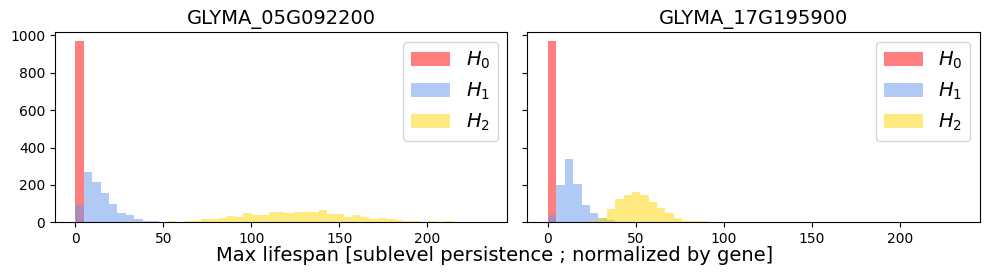

In [10]:
fs = 14; marker = ['D', 'o', 's']; color = ['red','cornflowerblue','gold']

fig, ax = plt.subplots(1,2, figsize=(10,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

bins = np.linspace(np.min(maxlife), np.max(maxlife)+1, 50)

for i in range(len(ax)):
    for k in range(maxlife.shape[2]):
        ax[i].hist(maxlife[i, :, k].ravel(), bins=bins, color=color[k], alpha=0.5, label='$H_{}$'.format(k))
    ax[i].legend(fontsize=fs)
    ax[i].set_title(transcriptomes[tidxs[i]], fontsize=fs)

fig.supxlabel('Max lifespan [{}level persistence ; normalized by {}]'.format(level, normtype), fontsize=fs, y=0.1)
fig.tight_layout();

filename = dst+'max_lifespan_{}level_{}.svg'.format(level, normtype)
#plt.savefig(filename, format='svg', dpi=100, bbox_inches='tight')

In [11]:
diags = [ [ [ rescale*orig_diags[i][j][k].copy()  for k in range(ndims) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]

numpairs, reduced = 0,0
minlife = 8

for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] = np.atleast_2d(diags[i][j][k][np.diff(diags[i][j][k]).squeeze() > minlife, :].squeeze())
            numpairs += len(diags[i][j][k])
         
        k = argmaxlife[i,j]
        if (len(diags[i][j][k]) == 0) & (len(orig_diags[i][j][k]) > 0):
            diags[i][j][k] = rescale*np.atleast_2d(orig_diags[i][j][k][0])
            numpairs += 1
            reduced +=1
            
print('Post number of life-birth pairs\t:', numpairs)
print('Reduced to null diagrams:\t', reduced)

Post number of life-birth pairs	: 32813
Reduced to null diagrams:	 0


In [12]:
isdiag = np.zeros(len(diags[0]), dtype=bool)

for cidx in range(len(isdiag)):
    dk = np.zeros(ndims)
    match = [None for i in range(len(dk))]
    for k in range(len(dk)):
        if (len(diags[0][cidx][k]) > 0) | (len(diags[1][cidx][k]) > 0):
            dk[k], match[k] = persim.bottleneck(diags[0][cidx][k], diags[1][cidx][k], matching=True)
    
    m = match[np.argmax(dk)]
    isdiag[cidx] = -1 in m[np.argmax(m[:,-1]), :]

filename = dst + '{}level_bottleneck_isdiagonal.csv'.format(level)
np.savetxt(filename, isdiag.reshape(1,-1), delimiter=',', fmt='%d')
print(filename)

../distance/D2/GLYMA_05G092200_vs_GLYMA_17G195900_gene/sublevel_bottleneck_isdiagonal.csv


In [13]:
diagh = [ [ None for k in range(ndims) ] for i in range(np.sum(ratios > 0)) ]

counter = 0
for i in range(len(diags)):
    for j in np.nonzero(ratios[i] > 0)[0]:
        for k in range(len(diags[i][j])):
            diagh[counter][k] = diags[i][j][k]
        counter += 1

print(len(diagh), len(diagh[0]), sep='\t')

1936	3


In [ ]:
initrow = 10
endrow = 100

bottleneck = np.zeros((endrow - initrow, len(diagh)))

ix = 0
for i in range(initrow, endrow, 1):
    for j in range(i+1, bottleneck.shape[1]):
        dk = np.zeros(ndims)
        for k in range(len(dk)):
            if (len(diagh[i][k]) > 0) | (len(diagh[j][k]) > 0):
                dk[k] = persim.bottleneck(diagh[i][k], diagh[j][k], matching=False)
                #dk[k] = ix*j
        bottleneck[ix,j] = np.max(dk)
    ix += 1

In [ ]:
initrow, endrow = 0,9
filename = dst + dst.split(os.sep)[-2] + '_{}level_bottleneck_{:05d}_{:05d}.csv'.format(level, initrow, endrow)
print(filename)
#pd.DataFrame(bottleneck).to_csv(filename, index=False, header=None)

# Bottleneck


In [56]:
np.nonzero(~isdiag)[0]

array([ 11,  34,  60,  92,  96, 111, 117, 138, 157, 185, 197, 208, 232,
       252, 262, 307, 313, 327, 343, 392, 400, 428, 471, 473, 478, 531,
       536, 562, 563, 585, 603, 604, 605, 614, 629, 667, 673, 698, 700,
       707, 717, 727, 742, 777, 787, 819, 820, 834, 865, 894, 904, 911,
       922, 923, 964])

In [74]:
cidx = 340
dk = np.zeros(ndims)
match = [None for i in range(len(dk))]
for k in range(len(dk)):
    if (len(diags[0][cidx][k]) > 0) | (len(diags[1][cidx][k]) > 0):
        dk[k], match[k] = persim.bottleneck(diags[0][cidx][k], diags[1][cidx][k], matching=True)
print(dk, np.round(np.max(dk),1), sep='\n')

[95.47567398  8.37709579  0.        ]
95.5


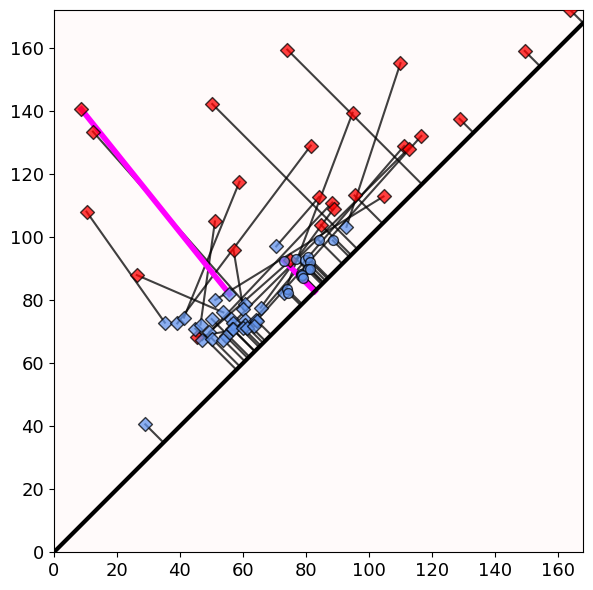

In [73]:
aux = np.max(maxlife[:, cidx, :])
fs = 16; marker = ['D', 'o', 's']; color = ['red','cornflowerblue','gold']
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for j in range(2):
    for k in range(ndims):
        if len(diags[j][cidx][k]) > 0:
            ax[i].scatter(diags[j][cidx][k][:,0], diags[j][cidx][k][:,1], alpha=0.75, label='$H_{}$'.format(k), 
                          marker=marker[k], c=color[j], s=50, linewidth=1, edgecolor='k', zorder=k+4)
for k in range(ndims):
    if (match[k] is not None) and (len(match[k]) > 0):
        for m in range(len(match[k])):
            if match[k][m,2] > 0:
                if match[k][m,0] == -1:
                    mid = np.mean(diags[1][cidx][k][ int(match[k][m,1]) ])
                    x1,y1 = mid,mid
                else:
                    x1,y1 = diags[0][cidx][k][ int(match[k][m,0]) ]
                
                if match[k][m,1] == -1:
                    mid = np.mean(diags[0][cidx][k][ int(match[k][m,0]) ])
                    x2,y2 = mid,mid
                else:
                    x2,y2 = diags[1][cidx][k][ int(match[k][m,1]) ]
                if m != np.argmax(match[k][:,2]):
                    ax[i].plot([x1,x2],[y1,y2], c='k', zorder=1, alpha=0.75)
                else:
                    ax[i].plot([x1,x2],[y1,y2], c='magenta', lw=4, zorder=2, alpha=1)
    
ax[i].scatter([0, aux] , [0, aux] , alpha=0)
ax[i].set_aspect('equal')
#ax[i].legend(loc='lower right', fontsize=fs)
ax[i].axline(xy1=(0,0), slope=1, c='k', zorder=3, lw=3)
ax[i].tick_params(labelsize=fs-3)
ax[i].margins(0)
ax[i].set_facecolor('snow')

fig.tight_layout()